In [1]:
%load_ext autoreload
%autoreload 2
    
import pandas as pd
import numpy as np

import patsy
import pystan
print(pystan.__version__)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

2.17.1.0


In [2]:
SEED = 123
DRAWS = 10000
BURNIN = 2000
#TUNE = 2000
CHAINS = 4
#CORES = 2

In [3]:
sleep = pd.read_csv('../datasets/sleepstudy.csv', index_col=0)
sleep['Subject'] = pd.Categorical(sleep['Subject'], ordered=False)
sleep.head()

,Reaction,Days,Subject
1,249.5600,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308


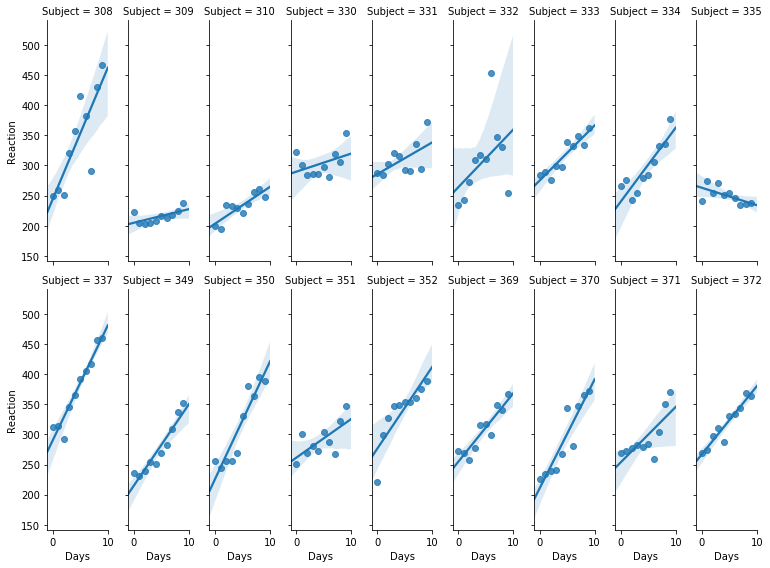

In [4]:
sns.lmplot(x="Days", y="Reaction", col="Subject", data=sleep, col_wrap=9, palette="muted", aspect=0.3, size=4)

In [5]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)
X.shape

(180, 2)

In [30]:
Z_intercept = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z_intercept = np.asarray(Z_intercept)

Z_slope = patsy.dmatrix('0 + Subject:Days', data=sleep, return_type='dataframe')
Z_slope = np.asarray(Z_slope)

Z = np.concatenate((Z_intercept, Z_slope), axis=1)
Z.shape

(180, 36)

In [29]:
Y = np.asarray(sleep['Reaction'])
Y.shape

(180,)

In [53]:
stan_code = """

data {
    int<lower=0> n_fixed_effects;
    int<lower=0> n_subjects;
    int<lower=0> n_observations;
    
    vector [n_observations] Y; // observations
    
    matrix [n_observations, n_fixed_effects] X; // design matrix for fixed effects
    matrix [n_observations, n_subjects*2] Z; // design matrix for random effects  
}

parameters {
    vector<lower=0>[1] beta_X_intercept;
    vector[1] beta_X_slope;

    vector[n_subjects] gamma_Z_intercept_raw;
    real<lower=0> scaler_Z_intercept;

    vector[n_subjects] gamma_Z_slope_raw;
    real<lower=0> scaler_Z_slope;

    real<lower=0> sigma_unexplained;
}

transformed parameters {
    vector [n_subjects] gamma_Z_intercept;
    vector [n_subjects] gamma_Z_slope;

    gamma_Z_intercept = gamma_Z_intercept_raw * scaler_Z_intercept;
    gamma_Z_slope = gamma_Z_slope_raw * scaler_Z_slope;
}

model {
    vector [n_fixed_effects] beta_X;
    vector [n_subjects*2] gamma_Z;
    
    beta_X = append_row(beta_X_intercept, beta_X_slope);
    gamma_Z = append_row(gamma_Z_intercept, gamma_Z_slope);
    
    beta_X_intercept ~ normal(0, 10000);
    beta_X_slope ~ normal(0, 100);

    scaler_Z_intercept ~ normal(0, 100);
    scaler_Z_slope ~ normal(0, 100);
    
    gamma_Z_intercept_raw ~ normal(0, 1);
    gamma_Z_slope_raw ~ normal(0, 1);
    
    sigma_unexplained ~ normal(0, 100);
    Y ~ normal(X * beta_X + Z * gamma_Z, sigma_unexplained);
}

"""

In [54]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a274e9bd888ffbeee4c2acd256c98159 NOW.


In [60]:
stan_data = {
    'n_fixed_effects': X.shape[1],
    'n_subjects': Z_intercept.shape[1],
    'n_observations': Y.shape[0],
    'Y': Y,
    'X': X,
    'Z': Z}

In [61]:
stan_fit = stan_model.sampling(data=stan_data, chains=4, iter=DRAWS+BURNIN, warmup=BURNIN, seed=SEED)

In [62]:
print(stan_fit)

Inference for Stan model: anon_model_a274e9bd888ffbeee4c2acd256c98159.
4 chains, each with iter=12000; warmup=2000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

                            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta_X_intercept[1]       251.47    0.06   7.45 236.66 246.66 251.48 256.27 266.26  18060    1.0
beta_X_slope[1]            10.45    0.01    1.7    7.1   9.34  10.44  11.55  13.84  12908    1.0
gamma_Z_intercept_raw[1]    0.04  2.7e-3   0.54  -1.01  -0.32   0.04    0.4   1.11  38772    1.0
gamma_Z_intercept_raw[2]   -1.54  3.0e-3   0.56  -2.71  -1.91  -1.52  -1.16  -0.48  36352    1.0
gamma_Z_intercept_raw[3]    -1.5  3.0e-3   0.56  -2.66  -1.86  -1.48  -1.11  -0.45  34640    1.0
gamma_Z_intercept_raw[4]    0.94  2.8e-3   0.54  -0.09   0.57   0.92    1.3   2.04  38835    1.0
gamma_Z_intercept_raw[5]    0.87  2.8e-3   0.54  -0.16   0.52   0.86   1.22   1.96  37315    1.0
gamma_Z_intercept_raw[6]    0.35

/Users/Alberto/miniconda3/envs/datascience/lib/python3.6/site-packages/matplotlib/figure.py:2223: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.     You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplotswith the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure "
/Users/Alberto/miniconda3/envs/datascience/lib/python3.6/site-packages/matplotlib/figure.py:2223: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.     You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplotswith the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure "
/Users/Alberto/miniconda3/envs/datascience/lib/python3.6/site-packages/matplotlib/figure.py:2223: UserWarning: Calling figure.constrained_layout, but figure not s

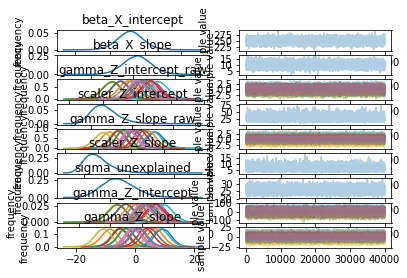

In [67]:
fig = stan_fit.plot()

In [64]:
trace = stan_fit.extract(permuted=True)

In [65]:
trace['gamma_Z_intercept'].shape

(40000, 18)